# *(Song, et al., 2016)*: Training excitatory-inhibitory recurrent network

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/examples/blob/main/recurrent_networks/Song_2016_EI_RNN.ipynb)

Implementation of the paper:

- Song, H. F. ,  G. R. Yang , and  X. J. Wang . "Training Excitatory-Inhibitory Recurrent Neural Networks for Cognitive Tasks: A Simple and Flexible Framework." Plos Computational Biology 12.2(2016):e1004792.

The original code is based on PyTorch (https://github.com/gyyang/nn-brain/blob/master/EI_RNN.ipynb). However, comparing with the PyTorch codes, the training on BrainPy speeds up nearly four folds. 

Here we will train recurrent neural network with excitatory and inhibitory neurons on a simple perceptual decision making task.

In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

bp.math.set_platform('cpu')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
bp.__version__, bd.__version__

('2.4.3', '0.0.0.6')

## Defining a perceptual decision making task

In [4]:
dataset = bd.cognitive.RatePerceptualDecisionMaking(dt=20.)
task = bd.cognitive.TaskLoader(dataset, batch_size=16)

## Define E-I recurrent network

Here we define a E-I recurrent network, in particular, no self-connections are allowed.

In [5]:
class RNN(bp.DynamicalSystem):
  r"""E-I RNN.

  The RNNs are described by the equations

  .. math::

      \begin{gathered}
      \tau \dot{\mathbf{x}}=-\mathbf{x}+W^{\mathrm{rec}} \mathbf{r}+W^{\mathrm{in}} 
      \mathbf{u}+\sqrt{2 \tau \sigma_{\mathrm{rec}}^{2}} \xi \\
      \mathbf{r}=[\mathbf{x}]_{+} \\
      \mathbf{z}=W^{\text {out }} \mathbf{r}
      \end{gathered}

  In practice, the continuous-time dynamics are discretized to Euler form
  in time steps of size :math:`\Delta t` as

  .. math::

     \begin{gathered}
      \mathbf{x}_{t}=(1-\alpha) \mathbf{x}_{t-1}+\alpha\left(W^{\mathrm{rec}} \mathbf{r}_{t-1}+ 
      W^{\mathrm{in}} \mathbf{u}_{t}\right)+\sqrt{2 \alpha \sigma_{\mathrm{rec}}^{2}} \mathbf{N}(0,1) \\
      \mathbf{r}_{t}=\left[\mathbf{x}_{t}\right]_{+} \\
      \mathbf{z}_{t}=W^{\mathrm{out}} \mathbf{r}_{t}
      \end{gathered}

  where :math:`\alpha = \Delta t/\tau` and :math:`N(0, 1)` are normally distributed
  random numbers with zero mean and unit variance, sampled independently at every time step.
  """

  def __init__(self, num_input, num_hidden, num_output, num_batch,
               dt=None, e_ratio=0.8, sigma_rec=0., seed=None,
               w_ir=bp.init.KaimingUniform(scale=1.),
               w_rr=bp.init.KaimingUniform(scale=1.),
               w_ro=bp.init.KaimingUniform(scale=1.)):
    super().__init__()

    # parameters
    self.tau = 100
    self.num_batch = num_batch
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    self.e_size = int(num_hidden * e_ratio)
    self.i_size = num_hidden - self.e_size
    if dt is None:
      self.alpha = 1
    else:
      self.alpha = dt / self.tau
    self.sigma_rec = (2 * self.alpha) ** 0.5 * sigma_rec  # Recurrent noise
    self.rng = bm.random.RandomState(seed=seed)

    # hidden mask
    mask = np.tile([1] * self.e_size + [-1] * self.i_size, (num_hidden, 1))
    np.fill_diagonal(mask, 0)
    self.mask = bm.asarray(mask, dtype=bm.float_)

    # input weight
    self.w_ir = bm.TrainVar(bp.init.parameter(w_ir, (num_input, num_hidden)))

    # recurrent weight
    bound = 1 / num_hidden ** 0.5
    self.w_rr = bm.TrainVar(bp.init.parameter(w_rr, (num_hidden, num_hidden)))
    self.w_rr[:, :self.e_size] /= (self.e_size / self.i_size)
    self.b_rr = bm.TrainVar(self.rng.uniform(-bound, bound, num_hidden))

    # readout weight
    bound = 1 / self.e_size ** 0.5
    self.w_ro = bm.TrainVar(bp.init.parameter(w_ro, (self.e_size, num_output)))
    self.b_ro = bm.TrainVar(self.rng.uniform(-bound, bound, num_output))

    self.reset_state(self.mode)

  def reset_state(self, batch_size):
    # variables
    self.h = bp.init.variable_(bm.zeros, self.num_hidden, batch_size)
    self.o = bp.init.variable_(bm.zeros, self.num_output, batch_size)

  def cell(self, x, h):
    ins = x @ self.w_ir + h @ (bm.abs(self.w_rr) * self.mask) + self.b_rr
    state = h * (1 - self.alpha) + ins * self.alpha
    state += self.sigma_rec * self.rng.randn(self.num_hidden)
    return bm.relu(state)

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def update(self, x):
    self.h.value = self.cell(x, self.h)
    self.o.value = self.readout(self.h[:, :self.e_size])
    return self.h.value, self.o.value

  @bm.cls_jit
  def predict(self, xs):
    self.h[:] = 0.
    return bm.for_loop(self.update, xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    os = os.reshape((-1, os.shape[-1]))
    return bp.losses.cross_entropy_loss(os, ys.flatten())

## Train the network on the decision making task

In [6]:
# Instantiate the network and print information
hidden_size = 50
with bm.environment(mode=bm.TrainingMode(batch_size=16)):
  net = RNN(num_input=dataset.num_inputs,
            num_hidden=hidden_size,
            num_output=dataset.num_outputs,
            num_batch=task.batch_size,
            dt=dataset.dt,
            sigma_rec=0.15)

In [7]:
# Adam optimizer
opt = bp.optim.Adam(lr=0.001, train_vars=net.train_vars().unique())

In [8]:
# gradient function
grad_f = bm.grad(net.loss,
                 grad_vars=net.train_vars().unique(),
                 return_value=True)

In [9]:
@bm.jit
def train(xs, ys):
  grads, loss = grad_f(xs, ys)
  opt.update(grads)
  return loss

The training speeds up nearly 4 times, comparing with the original PyTorch codes.

In [10]:
running_loss = []
for i_batch in range(20):
  for inputs, labels in task:
    loss = train(inputs, labels)
    running_loss.append(loss)
  print(f'Batch {i_batch}, Loss {np.mean(running_loss):0.4f}')
  running_loss = []

Batch 0, Loss 1.4421
Batch 1, Loss 0.3261
Batch 2, Loss 0.2789
Batch 3, Loss 0.2650
Batch 4, Loss 0.2515
Batch 5, Loss 0.2358
Batch 6, Loss 0.2271
Batch 7, Loss 0.2200
Batch 8, Loss 0.2155
Batch 9, Loss 0.2105
Batch 10, Loss 0.2081
Batch 11, Loss 0.2018
Batch 12, Loss 0.2009
Batch 13, Loss 0.1985
Batch 14, Loss 0.1960
Batch 15, Loss 0.1939
Batch 16, Loss 0.1911
Batch 17, Loss 0.1895
Batch 18, Loss 0.1862
Batch 19, Loss 0.1843


## Run the network post-training and record neural activity

In [11]:
num_trial = 500
task = bd.cognitive.TaskLoader(dataset, batch_size=num_trial)
inputs, trial_infos = task.get_batch()

net.reset_state(num_trial)
rnn_activity, action_pred = net.predict(inputs)
rnn_activity = np.asarray(rnn_activity)
trial_infos = np.asarray(trial_infos)

In [12]:
i_start = int(dataset.t_fixation / dataset.dt)
i_end = int((dataset.t_fixation + dataset.t_stimulus) / dataset.dt)

In [13]:
choice1_ind = trial_infos[-1] == 1
choice2_ind = trial_infos[-1] == 2
# response for ground-truth 0 and 1
stim_activity = [rnn_activity[i_start: i_end, choice1_ind],
                 rnn_activity[i_start: i_end, choice2_ind],]

### Plot neural activity from sample trials

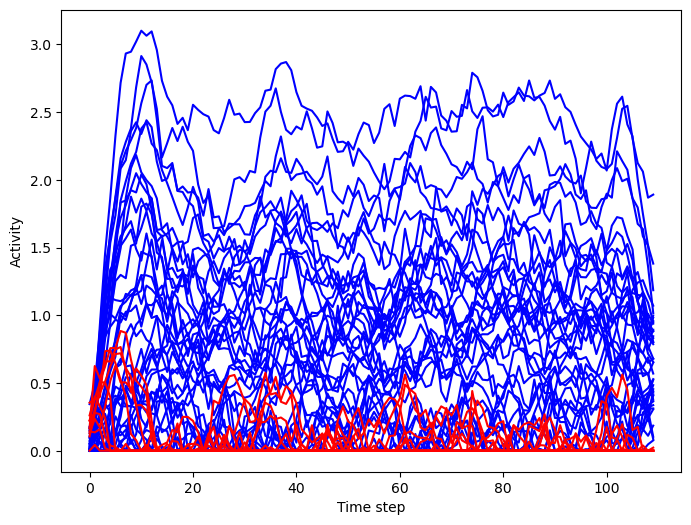

In [14]:
trial = 2
plt.figure(figsize=(8, 6))
_ = plt.plot(rnn_activity[:, trial, :net.e_size], color='blue', label='Excitatory')
_ = plt.plot(rnn_activity[:, trial, net.e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')
plt.show()

### Compute stimulus selectivity for sorting neurons

Here for each neuron we compute its stimulus period selectivity $d'$

In [15]:
mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
  activity = np.reshape(stim_activity[ground_truth],
                        (-1, net.num_hidden))
  mean_activity.append(np.mean(activity, axis=0))
  std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0] ** 2 + std_activity[1] ** 2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:net.e_size]),
                           np.argsort(selectivity[net.e_size:]) + net.e_size))

### Plot network connectivity sorted by stimulus selectivity

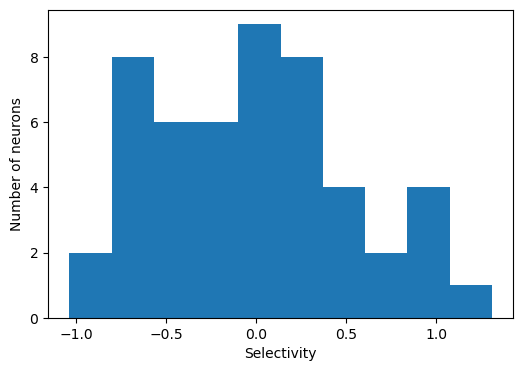

In [16]:
# Plot distribution of stimulus selectivity
plt.figure(figsize=(6, 4))
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')
plt.show()

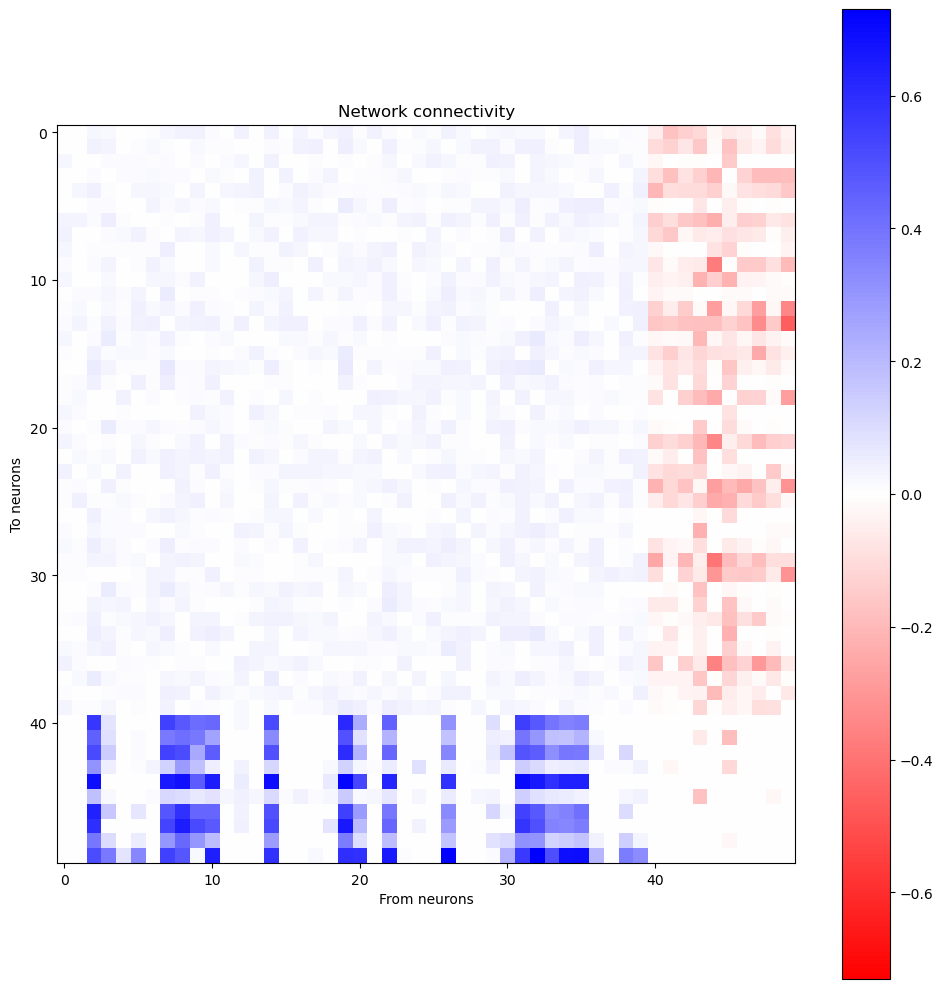

In [17]:
W = (bm.abs(net.w_rr) * net.mask).numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))

plt.figure(figsize=(10, 10))
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')
plt.tight_layout()
plt.show()